In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import random
import copy
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

In [3]:
def PCA(X , num_components):
     
    X_meaned = (X - np.mean(X , axis = 0)) / np.std(X, axis = 0)
    cov_mat = np.cov(X_meaned , rowvar = False)
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose())#.transpose()
     
    return X_reduced

In [4]:
locals = []
avg_timespans = []
gr_freqs = []
avg_sizes = []
icmp_packets = []
i = 0;

with open('window_data.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        nums = line.strip().split(' ')
        locals.append(int(nums[0]))
        avg_timespans.append(float(nums[1]))
        gr_freqs.append(int(nums[2]))
        avg_sizes.append(float(nums[3]))
        icmp_packets.append(int(nums[4]))

observations = np.vstack(( 
                        np.array(avg_timespans),
                        np.array(locals),
                        np.array(gr_freqs), 
                        np.array(avg_sizes), 
                        np.array(icmp_packets)))
observations = observations.transpose()
reduced_observations = PCA(observations, 2)

reduced_observations = reduced_observations[0:2, 0:10000]

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_data = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
reduced_iris = PCA(iris_data.iloc[:,0:3], 2)

In [6]:
def euclidian(array, cluster, n ,k ,dim): 
	cluster_content = [[] for i in range(k)]

	for i in range(n):
		min_distance = float('inf')
		situable_cluster = -1
		for j in range(k):
			distance = 0
			for q in range(dim):
				distance += (array[i][q]-cluster[j][q])**2
						
			distance = distance**(1/2)
			if distance < min_distance:
				min_distance = distance
				situable_cluster = j

		cluster_content[situable_cluster].append(array[i])
		
	return cluster_content

In [7]:
#mean = np.mean(reduced, axis = 0)
#centered_data = reduced - mean
cov_matrix = np.cov(reduced_observations)#centered_data)
inv_cov_matrix = np.linalg.inv(cov_matrix)
#print(np.shape(inv_cov_matrix))

In [8]:
def calc_mahalanobis(v1, v2, cov_inv):
    dim = len(v1)
    delta = []
    for i in range(dim):
            delta.append(v1[i] - v2[i])

    deltaS = []
    for i in range(dim):
        deltaS.append(0);
        for j in range(dim):
            deltaS[i] += delta[j]*cov_inv[j][i]
    d = 0;
    for i in range(dim):
        d += deltaS[i]*delta[i]

    d = d**(1/2)

    return d;

In [9]:
def mahalanobis(array, cluster, n ,k ,dim): 
	cluster_content = [[] for i in range(k)]

	for i in range(n):
		min_distance = 15
		situable_cluster = -1
		for j in range(k):
			d = calc_mahalanobis(array[i], cluster[j], inv_cov_matrix)
			if d < min_distance:
				min_distance = d
				situable_cluster = j

		cluster_content[situable_cluster].append(array[i])
		
	return cluster_content

In [10]:
def cluster_update(cluster, cluster_content, dim):
	k = len(cluster)
	for i in range(k): #по i кластерам
		for q in range(dim): #по q параметрам
			updated_parameter = 0
			for j in range(len(cluster_content[i])): 
				updated_parameter += cluster_content[i][j][q]
			if len(cluster_content[i]) != 0:
				updated_parameter = updated_parameter / len(cluster_content[i])
			cluster[i][q] = updated_parameter
	return cluster

max_cluster_value = -40

def clusterization(array, k, metrics):
	n = len(array)  
	dim = len(array[0])  

	
	cluster = [[0 for i in range(dim)] for q in range(k)] 
	cluster_content = [[] for i in range(k)] 

	for i in range(dim):
		for q in range(k):
			cluster[q][i] = random.randint(max_cluster_value, 0) 

	cluster_content = metrics(array, cluster, n , k, dim)

	privious_cluster = copy.deepcopy(cluster)
	while 1:
		cluster = cluster_update(cluster, cluster_content, dim)
		cluster_content = metrics(array, cluster, n, k, dim)
		if cluster == privious_cluster:
			return cluster, cluster_content
		privious_cluster = copy.deepcopy(cluster)

def prepare_data(data):
	to_clusterize = []
	for i in range(len(data[0])):
		to_clusterize.append([data[0][i], data[1][i]])
	return to_clusterize

2  clusters total


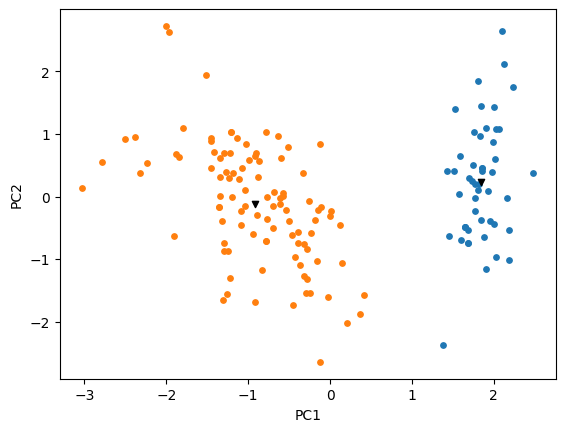

In [15]:
import matplotlib.colors as mcolors

to_clusterize = prepare_data(reduced_iris)

centers, cl = clusterization(to_clusterize, 2, euclidian)# mahalanobis)
print(len(centers), " clusters total")

cl_dots = []
for i in range(len(centers)):
    cl_dots.append(np.array(cl[i]).transpose())

fig, ax = plt.subplots(1)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
colors = mcolors.TABLEAU_COLORS
ax.set_prop_cycle

for i in range(len(centers)):
    plt.scatter(cl_dots[i][0], cl_dots[i][1], s = 15)
    plt.scatter(centers[i][0], centers[i][1], c = 'black', s = 20, marker = "v")